# Classifier for Predicting Smoker Status 

Can we predict the level of a smoker (Has, Quit, Currently) with biometric data?
I'm not sure, but let's find out.

We'll start with the smoking-drinking-dataset available here:https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset



In [1]:
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

/kaggle/input/smoking-drinking-dataset/smoking_driking_dataset_Ver01.csv


In [2]:
#read in the data to a dataframe
df = pd.read_csv('/kaggle/input/smoking-drinking-dataset/smoking_driking_dataset_Ver01.csv')
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


In [3]:
print("Shape",df.shape)
print(df.describe())

Shape (991346, 24)
                 age         height         weight      waistline  \
count  991346.000000  991346.000000  991346.000000  991346.000000   
mean       47.614491     162.240625      63.284050      81.233358   
std        14.181339       9.282957      12.514241      11.850323   
min        20.000000     130.000000      25.000000       8.000000   
25%        35.000000     155.000000      55.000000      74.100000   
50%        45.000000     160.000000      60.000000      81.000000   
75%        60.000000     170.000000      70.000000      87.800000   
max        85.000000     190.000000     140.000000     999.000000   

          sight_left    sight_right      hear_left     hear_right  \
count  991346.000000  991346.000000  991346.000000  991346.000000   
mean        0.980834       0.978429       1.031495       1.030476   
std         0.605949       0.604774       0.174650       0.171892   
min         0.100000       0.100000       1.000000       1.000000   
25%         0.

This data is pretty clean (No minimums less than 1), and sizeable (991346 rows of data).

Are there any categorical variables? Let's look at a row to see.


In [4]:
df.iloc[0,:]

sex                  Male
age                    35
height                170
weight                 75
waistline            90.0
sight_left            1.0
sight_right           1.0
hear_left             1.0
hear_right            1.0
SBP                 120.0
DBP                  80.0
BLDS                 99.0
tot_chole           193.0
HDL_chole            48.0
LDL_chole           126.0
triglyceride         92.0
hemoglobin           17.1
urine_protein         1.0
serum_creatinine      1.0
SGOT_AST             21.0
SGOT_ALT             35.0
gamma_GTP            40.0
SMK_stat_type_cd      1.0
DRK_YN                  Y
Name: 0, dtype: object

Seems we have two binary categorical variables. 
- Sex (F/M) 
- Drinker (yes/no)

Both are binary so let's encode those variables with True/False for 1s and 0s later.

At the same time, let's address our target variables of Smoking.
- SMK_stat_type_cd = Smoking state, 1(never), 2(used to smoke but quit), 3(still smoke)
- We'll encode this as 0 never smoked, 1 has or is a smoker

In [5]:
df["female"] = pd.get_dummies(df['sex'],1).iloc[:,0]

for i in range(df.shape[0]):
    if df['female'][i] == False:
        df['female'][i] = 0
    else:
        df['female'][i] = 1
        
df.iloc[:,[0,-1]]

/tmp/ipykernel_20/337220530.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['female'][i] = 0


,sex,female
0,Male,0
1,Male,0
2,Male,0
3,Male,0
4,Male,0
...,...,...
991341,Male,0
991342,Male,0
991343,Female,1
991344,Male,0


In [6]:
df["drinker"] = pd.get_dummies(df['DRK_YN'],0).iloc[:,1]
for i in range(df.shape[0]):
    if df['drinker'][i] == False:
        df['drinker'][i] = 0
    else:
        df['drinker'][i] = 1
        

df.iloc[:,[-3,-1]]


/tmp/ipykernel_20/901829138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['drinker'][i] = 1


,DRK_YN,drinker
0,Y,1
1,N,0
2,N,0
3,N,0
4,N,0
...,...,...
991341,N,0
991342,N,0
991343,Y,1
991344,N,0


In [7]:
df['smokers'] = df['SMK_stat_type_cd'] - 1 #sets ones to zero, twos to ones, and threes to twos
df['smokers'].loc[df['smokers'] > 1  ] = 1 #changes twos to ones
df['smokers'].describe() #mean shows us how many smokers in dataset

/tmp/ipykernel_20/1206084603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smokers'].loc[df['smokers'] > 1  ] = 1 #changes twos to ones


count    991346.000000
mean          0.392300
std           0.488263
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: smokers, dtype: float64

In [8]:
# Check for NaNs
for i in df.columns:
    print(i,":",df[i].isna().sum())

sex : 0
age : 0
height : 0
weight : 0
waistline : 0
sight_left : 0
sight_right : 0
hear_left : 0
hear_right : 0
SBP : 0
DBP : 0
BLDS : 0
tot_chole : 0
HDL_chole : 0
LDL_chole : 0
triglyceride : 0
hemoglobin : 0
urine_protein : 0
serum_creatinine : 0
SGOT_AST : 0
SGOT_ALT : 0
gamma_GTP : 0
SMK_stat_type_cd : 0
DRK_YN : 0
female : 0
drinker : 0
smokers : 0


In [9]:
df.drop('SMK_stat_type_cd', axis=1, inplace=True)
df.drop("DRK_YN", axis=1, inplace=True)
df.drop("sex", axis=1, inplace =True)
df.columns

Index(['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right',
       'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole',
       'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein',
       'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'female',
       'drinker', 'smokers'],
      dtype='object')

Now we have all numerical data, a coded target variable, and cleaned up dataframe without NaNs.

Our dataset isn't totally balanced, we see that 39.2% of respondents are or were smokers, and the remainder never started.

Let's move onto visualize and model the data. First we'll run a correlation plot to see how bad the multicollinearity is on this data.

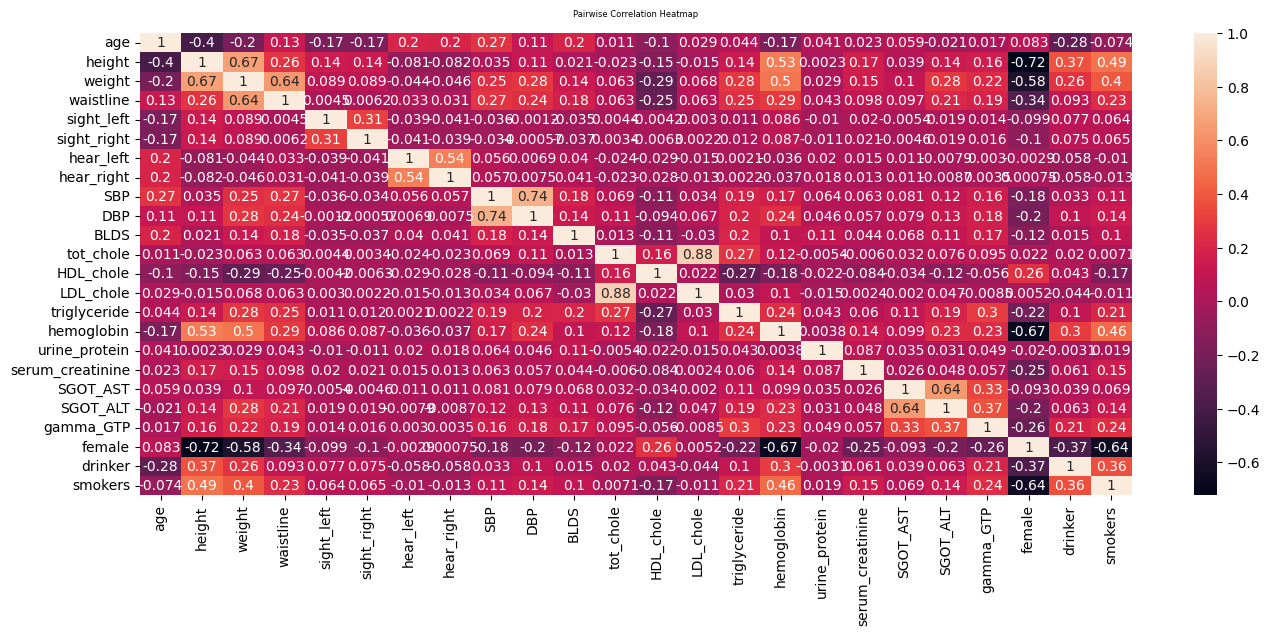

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(method='pearson'), annot=True)
heatmap.set_title('Pairwise Correlation Heatmap', fontdict={'fontsize':6}, pad=12);

Well, 
- there are some highly correlated columns depending up a person's sex.
- height is highly correlated to weight.
- waistline is highly correlated to weight.
- Systolic Blood Pressures is highly correlated to Diastolic Blood Pressure.
- LDL Cholestoral is highly correlated to total cholestoral.
- SGOT_AST(Glutamate-oxaloacetate transaminase)(Aspartate transaminase) correlates highly with (Alanine transaminase).

This is expected in all but the sex category. 
- The sex of a person is descriptive. 
- The rest of these are examples of measuring similar attributes differently.

This presents options: 
1. We'll have to progress through forward and backward selection to see which ones present collinearity issues in a linear regression
2. Or we can see if decision trees do a good job with the data first 
- A: Base trees will be prone to overfitting
- B: ADA Boost will be better than Base Trees
- C: Random Forest will be able to handle the collinearity and pull patterns across collinearity.

Let's try # 2C first.


In [11]:
Xtr,Xte, ytr, yte = train_test_split(df.iloc[:,0:-2],df.iloc[:,-1],test_size=0.2,shuffle=True,random_state =12)
print(Xtr.head())

print("Shapes (train):",Xtr.shape,ytr.shape)
print("Shapes (test):", Xte.shape,yte.shape)

        age  height  weight  waistline  sight_left  sight_right  hear_left  \
882938   65     175      65       91.0         0.7          0.7        1.0   
619355   45     145      50       73.0         0.9          0.8        1.0   
381918   55     155      50       70.0         0.7          1.0        1.0   
176986   50     175      75       86.2         1.5          2.0        1.0   
853639   30     160      70       82.0         1.2          1.2        1.0   

        hear_right    SBP   DBP  ...  HDL_chole  LDL_chole  triglyceride  \
882938         1.0  112.0  72.0  ...       29.0       93.0          73.0   
619355         1.0  110.0  70.0  ...       93.0       97.0         104.0   
381918         1.0  125.0  63.0  ...       77.0      219.0         116.0   
176986         1.0  102.0  80.0  ...       49.0      129.0         129.0   
853639         1.0  139.0  89.0  ...       46.0      116.0         199.0   

        hemoglobin  urine_protein  serum_creatinine  SGOT_AST  SGOT_ALT  \

For documentation sake, what are the Random Forest Model parameters?

In [12]:
rf = RandomForestClassifier(random_state = 12)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12,
 'verbose': 0,
 'warm_start': False}


Okay, a few things stay a few things to change. Gini Coefficient is good and will stay (detecting purity of the splits) and a square root of the number of features will help the classifier mitigate the collinearity. 

Moving on to things we'll change, we want to use stumps (max depth 2), expect a few samples per leaf (we'll say 12 to start), want to run the job in parallel (n_jobs = -1), want to bootstrap the data for randomization (so central limit theorem helps us avoid overfitting), and a whole bunch of trees (say 1200). 

We set those parameters, train the model with the training data, and then predict both the test and train outputs with our new model. Verbose is set to 1 so we will get to see some of the progress.

In [13]:
class1rf = RandomForestClassifier(n_estimators=212,  criterion='gini',max_features='sqrt',
                                  bootstrap=True, max_depth=2, min_samples_leaf = 12, n_jobs=-1,
                                 verbose=1, ccp_alpha = .00) 

#fit the classifier to training data
class1rf.fit(Xtr,ytr)                                  
print("Random Forest fit. \n Predicting Train Values..." )

#predict the training dataset
yarf = class1rf.predict(Xtr)

#predict the test dataset
yarf2 = class1rf.predict(Xte)                              

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:   47.1s finished


Random Forest fit. 
 Predicting Train Values...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 212 out of 212 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 212 out of 212 | elapsed:    1.0s finished


With our fit training data, and predicted train and test set data, let's score the model.

In [14]:
C1Trroc = roc_auc_score(ytr,yarf)
C1Teroc = roc_auc_score(yte,yarf2)

C1Trps = precision_score(ytr,yarf)
C1Teps = precision_score(yte,yarf2)

C1Trrs = recall_score(ytr,yarf)
C1Ters = recall_score(yte,yarf2)

C1Trf1 = 2*(C1Trrs * C1Trps)/(C1Trrs + C1Trps)
C1Tef1 =  2*(C1Ters * C1Teps)/(C1Ters + C1Teps)

scoring = pd.DataFrame({
             "model" : ["Train", "Test"],
             "Precision" : [C1Trps,C1Teps],
             "Recall" : [C1Trrs,C1Ters],
             "F1 Score" : [C1Trf1,C1Tef1],
             "ROC-AUC": [C1Trroc,C1Teroc]
             
             })
scoring 

,model,Precision,Recall,F1 Score,ROC-AUC
0,Train,0.699633,0.822394,0.756063,0.797185
1,Test,0.700366,0.822494,0.756533,0.797866


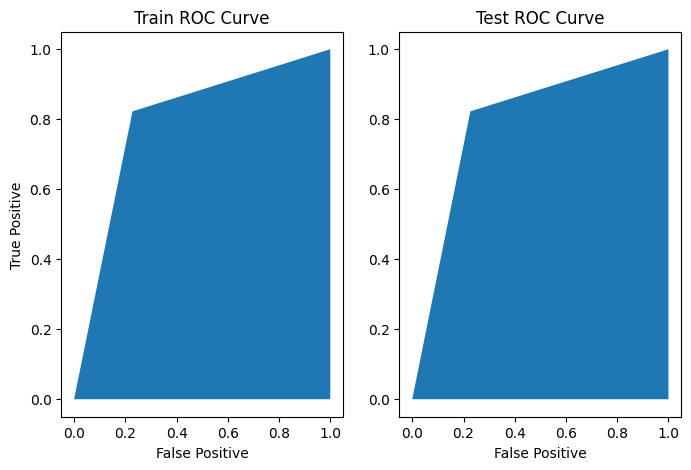

Train AUC: 0.7971850069427748 	 	 Test AUC: 0.7978659218145313


In [15]:
C1Trfp,C1Trtp, _ = roc_curve(ytr,yarf)
C1Tefp,C1Tetp, _ = roc_curve(yte,yarf2)
#Training ROC
plt.figure(figsize=[8,5])
plt.subplot(121)
plt.fill_between(C1Trfp,C1Trtp)
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.title("Train ROC Curve");

plt.subplot(122)
#Testing ROC 
plt.fill_between(C1Tefp,C1Tetp)

plt.xlabel("False Positive")
plt.title("Test ROC Curve");
plt.show()
print("Train AUC:", C1Trroc ,"\t \t Test AUC:" , C1Teroc )

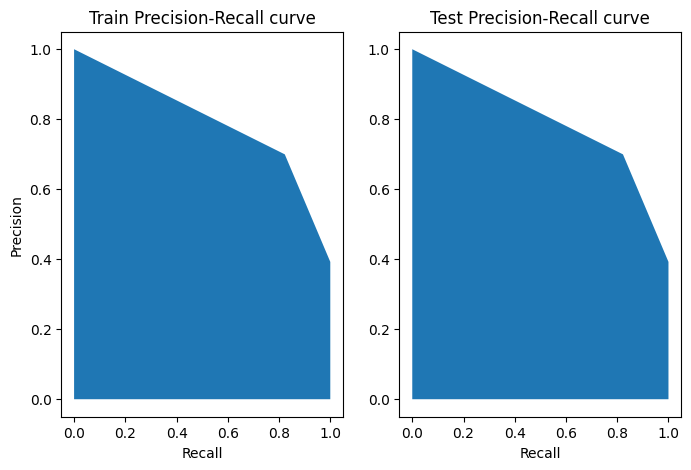

In [16]:
C1Trprec,C1Trrecall, _ = precision_recall_curve(ytr,yarf)
C1Teprec,C1Terecall, _ = precision_recall_curve(yte,yarf2)
#Training Precision Recall Curve
plt.figure(figsize=[8,5])
plt.subplot(121)
plt.fill_between(C1Trrecall,C1Trprec)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

plt.subplot(122)
#Training Precision Recall Curve
plt.fill_between(C1Trrecall,C1Trprec)
#plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve");
plt.show()

These results aren't bad, we are over 81% on recall, 70% on precision, and have F1 scores in the .75 area for both train and test sets. This tells us we have probably not overfit our model because the metrics are similar whether the model has seen the data (training set) or is new data (test set). Moreover, area under the ROC-AUC and Precision Recall Curves appears to illustrate identical shapes and more area identified than blank. We have succussfully fit a model in under 10 minutes, tested, scored, and completed our cursory analysis. 

However, we haven't tuned this model at all. The hyperparameters we chose were just guesses. The cursory analysis does show that this method is promising, but to deploy a model like this we'd like better scores. Therefore, the value of the cursory model justifies investing time to tune the model. Let's see if we can increase those scores by tuning the hyperparameters.

Here, we'll use the gridsearchCV method to tune our random forest.
- Start by choosing the parameters for the grid.
- Train the data on each of the sets of parameters.
- Select the best set of parameters.
- Predict train outcomes and then test outcomes.
- Run metrics on those outcomes to gauge efficacy, overfitting, and final recommendation.


In [17]:
# Build the grid of options 
grids = {
        'n_estimators':[int(N) for N in np.linspace(100,1000,3)],
        'max_depth': [2,3,4,5]
        #'min_samples_split': [.1,.01,.05],
        #'min_samples_leaf': [2,27,52,104],   
        #'max_samples' : [ int(N) for N in np.linspace(1000,12000,6)] 
        }
# Let people see the output of this step...
grids

{'n_estimators': [100, 550, 1000], 'max_depth': [2, 3, 4, 5]}

In [18]:
# run grid search on random forest classifier, with grid options, 
# on a single proc (the other 3 are for RandomForest to run full blast),
# with 3 fold validation, verbose output (3), scoring based on f1 score,
# and raise an error if score is nan.
hypertesting = GridSearchCV(class1rf, 
                            param_grid=grids, n_jobs=1, 
                            cv= 3, verbose = 3, scoring='f1',
                            error_score ='raise'  ).fit(Xtr,ytr)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


[CV 1/3] END .....max_depth=2, n_estimators=100;, score=0.757 total time=  18.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


[CV 2/3] END .....max_depth=2, n_estimators=100;, score=0.758 total time=  18.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


[CV 3/3] END .....max_depth=2, n_estimators=100;, score=0.764 total time=  17.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    2.9s finished


[CV 1/3] END .....max_depth=2, n_estimators=550;, score=0.758 total time= 1.5min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    2.9s finished


[CV 2/3] END .....max_depth=2, n_estimators=550;, score=0.754 total time= 1.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    2.9s finished


[CV 3/3] END .....max_depth=2, n_estimators=550;, score=0.761 total time= 1.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.3s finished


[CV 1/3] END ....max_depth=2, n_estimators=1000;, score=0.754 total time= 2.6min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.3s finished


[CV 2/3] END ....max_depth=2, n_estimators=1000;, score=0.749 total time= 2.6min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.4s finished


[CV 3/3] END ....max_depth=2, n_estimators=1000;, score=0.756 total time= 2.6min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 1/3] END .....max_depth=3, n_estimators=100;, score=0.781 total time=  24.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


[CV 2/3] END .....max_depth=3, n_estimators=100;, score=0.770 total time=  23.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


[CV 3/3] END .....max_depth=3, n_estimators=100;, score=0.768 total time=  23.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    3.4s finished


[CV 1/3] END .....max_depth=3, n_estimators=550;, score=0.773 total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    3.3s finished


[CV 2/3] END .....max_depth=3, n_estimators=550;, score=0.774 total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    3.4s finished


[CV 3/3] END .....max_depth=3, n_estimators=550;, score=0.772 total time= 1.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.0s finished


[CV 1/3] END ....max_depth=3, n_estimators=1000;, score=0.773 total time= 3.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.1s finished


[CV 2/3] END ....max_depth=3, n_estimators=1000;, score=0.772 total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.0s finished


[CV 3/3] END ....max_depth=3, n_estimators=1000;, score=0.772 total time= 3.5min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


[CV 1/3] END .....max_depth=4, n_estimators=100;, score=0.778 total time=  29.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


[CV 2/3] END .....max_depth=4, n_estimators=100;, score=0.778 total time=  28.9s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


[CV 3/3] END .....max_depth=4, n_estimators=100;, score=0.779 total time=  29.1s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    4.0s finished


[CV 1/3] END .....max_depth=4, n_estimators=550;, score=0.779 total time= 2.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    3.8s finished


[CV 2/3] END .....max_depth=4, n_estimators=550;, score=0.782 total time= 2.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    4.2s finished


[CV 3/3] END .....max_depth=4, n_estimators=550;, score=0.780 total time= 2.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.1s finished


[CV 1/3] END ....max_depth=4, n_estimators=1000;, score=0.781 total time= 4.4min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.8s finished


[CV 2/3] END ....max_depth=4, n_estimators=1000;, score=0.779 total time= 4.3min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.8s finished


[CV 3/3] END ....max_depth=4, n_estimators=1000;, score=0.779 total time= 4.3min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 1/3] END .....max_depth=5, n_estimators=100;, score=0.784 total time=  33.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 2/3] END .....max_depth=5, n_estimators=100;, score=0.785 total time=  33.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 3/3] END .....max_depth=5, n_estimators=100;, score=0.783 total time=  33.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    4.2s finished


[CV 1/3] END .....max_depth=5, n_estimators=550;, score=0.785 total time= 2.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    4.2s finished


[CV 2/3] END .....max_depth=5, n_estimators=550;, score=0.785 total time= 2.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    4.2s finished


[CV 3/3] END .....max_depth=5, n_estimators=550;, score=0.785 total time= 2.9min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.5s finished


[CV 1/3] END ....max_depth=5, n_estimators=1000;, score=0.785 total time= 5.2min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.9s finished


[CV 2/3] END ....max_depth=5, n_estimators=1000;, score=0.785 total time= 5.2min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.6s finished


[CV 3/3] END ....max_depth=5, n_estimators=1000;, score=0.785 total time= 5.2min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  4.4min finished


In [19]:
seee = pd.DataFrame(hypertesting.cv_results_)
seee

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,16.491127,0.299670,1.594275,0.010710,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.757101,0.757983,0.764407,0.759831,0.003256,10
1,82.722003,1.030510,3.968035,0.011720,2,550,"{'max_depth': 2, 'n_estimators': 550}",0.757735,0.753930,0.761191,0.757619,0.002965,11
2,147.617248,0.038047,6.360943,0.046826,2,1000,"{'max_depth': 2, 'n_estimators': 1000}",0.753885,0.748840,0.755627,0.752784,0.002878,12
3,22.070948,0.103248,1.741204,0.122068,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.780977,0.770300,0.768150,0.773142,0.005609,7
4,111.578309,0.862067,4.388663,0.079882,3,550,"{'max_depth': 3, 'n_estimators': 550}",0.773316,0.773884,0.772155,0.773119,0.000719,8
5,201.410285,2.195784,7.083947,0.064029,3,1000,"{'max_depth': 3, 'n_estimators': 1000}",0.772759,0.772022,0.771768,0.772183,0.000420,9
6,27.366548,0.176517,1.733880,0.007589,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.778224,0.777589,0.779104,0.778306,0.000621,6
7,140.442000,0.761168,5.028583,0.152173,4,550,"{'max_depth': 4, 'n_estimators': 550}",0.778945,0.781501,0.779673,0.780040,0.001075,4
8,252.422224,0.886022,7.919187,0.174023,4,1000,"{'max_depth': 4, 'n_estimators': 1000}",0.780939,0.779235,0.779116,0.779763,0.000833,5
9,31.909369,0.069631,1.773300,0.004324,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.783775,0.784511,0.782650,0.783645,0.000765,3


In [20]:
#predict the test set with optimized model
preds = hypertesting.predict(Xte)
 
#score the test set (ROC-AUC, Precision, Recall, & F1)
C2Teroc = roc_auc_score(yte,preds)
 
C2Teps = precision_score(yte,preds)
 
C2Ters = recall_score(yte,preds)
 
C2Tef1 =  2*(C2Ters * C2Teps)/(C2Ters + C2Teps)

#add scores to dataframe of metrics above for analysis
scoring.loc[len(scoring.index)] = ['GridSearch + Test Set', C2Teps, C2Ters, C2Tef1,C2Teroc] 
scoring

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 550 out of 550 | elapsed:    3.1s finished


,model,Precision,Recall,F1 Score,ROC-AUC
0,Train,0.699633,0.822394,0.756063,0.797185
1,Test,0.700366,0.822494,0.756533,0.797866
2,GridSearch + Test Set,0.693927,0.905314,0.785650,0.823994


The GridSearch returned a best F1 score of 78.4% on the training data. The dataframe above shows that the F1 Score on the unseen test set is even higher at 78.53%. This leads us to believe that the model is not overfit. 

Additionally, the optimized model results in a 2.5% increase in F1 scores versus the untuned model (76% on test set vs 78.5% on test set). This is a substantial increase, and warrants a look under the hood. Further analysis shows that the Recall of the tuned model increased 7 points, and the Precision stayed roughly the same (a loss of .5% in precision). The extra hour of processing time to run the grid search did increase the value of the model.

Before we go, we'll generate the ROC and Precision-Recall curves of the intial testset results and the final test set results.

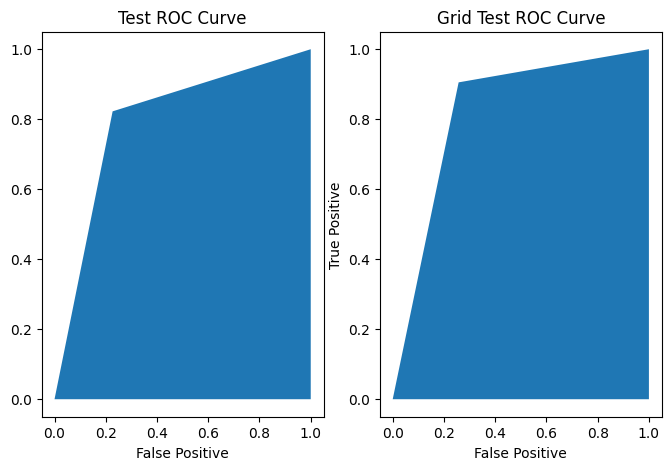

Test AUC: 0.7978659218145313 	 	 GridSearch Test AUC: 0.8239942687462241


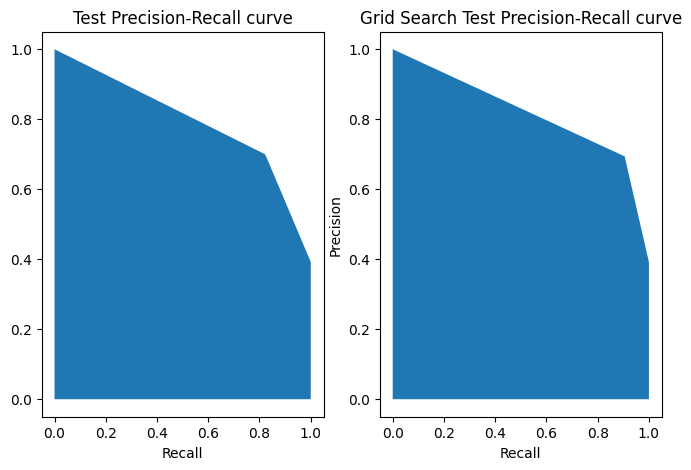

In [21]:
C2Tefp,C2Tetp, _ = roc_curve(yte,preds) 

plt.figure(figsize=[8,5])
plt.subplot(121)
#Initial Test ROC 
plt.fill_between(C1Tefp,C1Tetp)

plt.xlabel("False Positive")
plt.title("Test ROC Curve");

#Grid Test ROC
plt.subplot(122)
plt.fill_between(C2Tefp,C2Tetp)
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.title("Grid Test ROC Curve");


plt.show()
print("Test AUC:", C1Teroc ,"\t \t GridSearch Test AUC:" , C2Teroc )

C2Teprec,C2Terecall, _ = precision_recall_curve(yte, preds) 

 
plt.figure(figsize=[8,5])
plt.subplot(121)
#Initial Testing Precision Recall Curve
plt.fill_between(C1Trrecall,C1Trprec)
#plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve")


plt.subplot(122)
# Final Testing Precision Recall Curve
plt.fill_between(C2Terecall,C2Teprec)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Grid Search Test Precision-Recall curve");
plt.show()

Yes, there is appreciable improvment in the output graphics for ROC and Precision-Recall. But they are certainly not earth shattering. I would agree that there is more tuning to be done. We could certainly continue to tune this model. Viable reasons include a competition or because a client was willing to pay for it. However, the initial grid search tells us that we have reached diminishing returns on this particular model. Without feature engineering, different data, or other manipulation of the setup, this model is probably within 10% of the final results. 

Here, we revert to the initial research question, and deliver our results.

Can we determine if a person was a smoker based on this dataset?
- The answer is yes, with a 90% recall rate and 69% precision on those predictions. 
- In other words our model can find 9/10 of the smokers, and is accurate in 7/10 predictions.

The only thing left to determine are the indicators the model is using for these predictions. 

How is the model making these decisions?

We'll use the shapely values to illustrate how the model thinks on three random cases. 
- First we'll build the explainer on the gridsearch best model.
- Then we'll output a graphic representation (forceplot) of why the model returned the probability for each case.
- And finally check whether the model categorized each case correctly.


In [22]:
import shap  
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(hypertesting.best_estimator_)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [23]:
# Calculate Shap values on a random instance
chosen_instance = Xte.iloc[312,:]
shap_values = explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance)

Here we see that the most significant factor in the non-smoking classification is that the subject is female. Hemoglobin, height, weight, serum creatine score, and waistline size also contribute to the 0 class score. However, triglyceride levels and gamma_GTP scores keep this classification from being a perfect zero log-odds. The model log odds for a smoker are .12, which is less than the .5 decision boundary between the classes. The model classifies this as a non-smoker.


In [24]:
print(f"The actual value from the test set for record 312 is {yte.iloc[312]}, which corroborates the model.")

The actual value from the test set for record 312 is 0.0, which corroborates the model.


In [25]:
# Calculate Shap values on a random instance
chosen_instance = Xte.iloc[712,:]
shap_values = explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance)

Here we see that the most significant factor in the smoking classification is that the subject is male. Height, gamma_GTP, and triglyceride levels contribute to that score in descending importance. The age of 40 is significant, but not as much so. Hemoglobin and weight characteristics of the subject reduce the log-odds score, but not below the threshold for a decision. The model log odds for a smoker are .67, which is more than the .5 decision boundary for the model. So the model classifies this as a smoker.

In [26]:
print(f"The actual value from the test set is {yte.iloc[712]}, which corroborates the model.")

The actual value from the test set is 1.0, which corroborates the model.


In [27]:
# Calculate Shap values on a random instance
chosen_instance = Xte.iloc[1212,:]
shap_values = explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance)

Here, again, we see that the most significant factor in the non-smoking classification is that the subject is female. Hemoglobin, Gamma_GTP, height, serum creatine levels and weight contribute to the 0 class score in descending importance. However, hemoglobin levels keep this classification from being a perfect zero log-odds. The model log odds for a smoker are .16, which is less than the .5 decision boundary between the classes. The model classifies this as a non-smoker.


In [28]:
print(f"The actual value from the test set is {yte.iloc[1212]}, which corroborates the model.")

The actual value from the test set is 0.0, which corroborates the model.


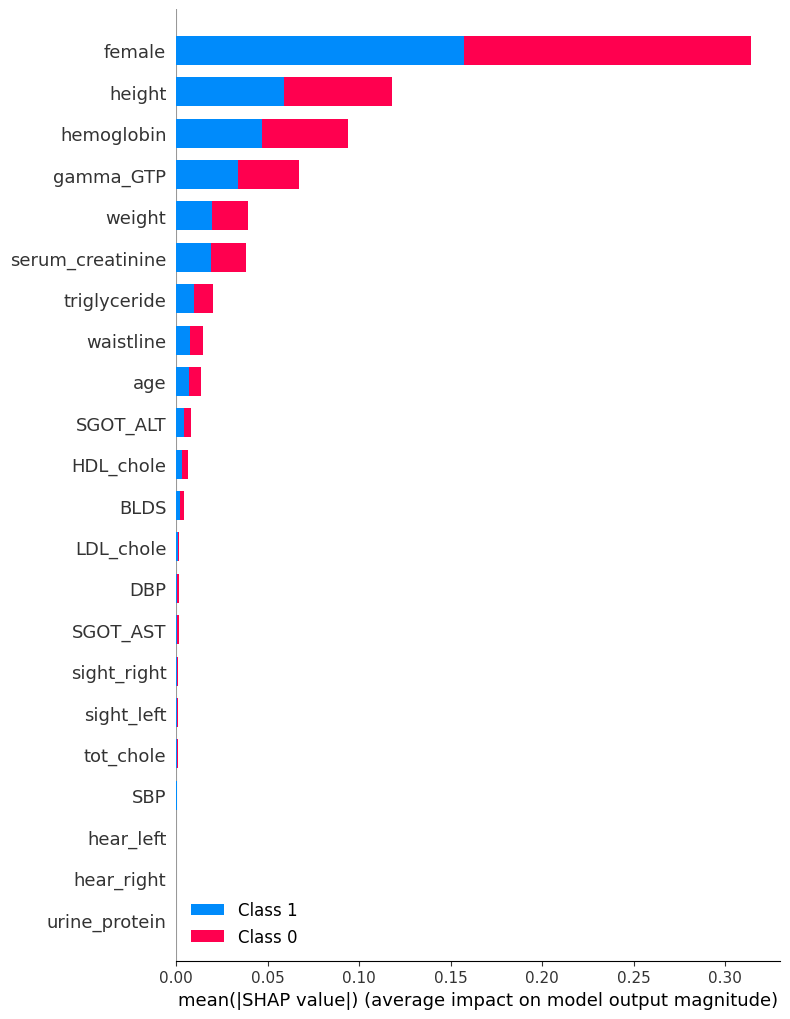

In [29]:
#run shap_values on whole test set for summary plot
vals = explainer.shap_values(Xte)
shap.summary_plot(vals,  max_display = 22, feature_names=Xte.columns)

The summary plot above tells us which features have the most importance in the model (gender is greatest). Since the Random Forest of decision trees has many contradictory decision points (based on the values in adjacent features for any given observation) this type of plot is one of the most powerful ways of delineating what features contribute heavily to a classification of 1 or 0.

Conclusion: We can see who is or was a smoker based on their vital signs with well better than 50% guessing accuracy, (69.4%) and we can find 90% of those smokers with the model. This is good. 

However, this model doesn't have a high enough F1 score (over 80% precision and recall) to prescribe outcomes in an automated fashion.

Thanks for taking a moment to look at this notebook.
